###### https://github.com/moebg/spoken-digit-recognition/blob/master/src/spoken_digit.py

###### dataset 구성하는데 참고하였습니다.

In [1]:


import torch
import os
import random
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, TensorDataset

import librosa
import librosa.display
import numba.decorators
import numpy as np
import matplotlib.pyplot as plt



file_path = "C:/Projects/keras_talk/keras/intern/0713/recordings/"
files = os.listdir(file_path)

utterance_length = 28
train_size = 1400
test_size = 100

EPOCHS = 15
BATCH_SIZE = 50



##### zero padding  >>  28*28 size  

In [2]:

# zero padding -> (20, utterance_length)
def padding( mfcc_feature, utterance_length ):
    S = mfcc_feature.shape[1]
    U = utterance_length
    if S >= U:
        #return mfcc_feature[:,:U]
        mfcc_feature = mfcc_feature[:,:U]
        return np.pad( mfcc_feature, ((4,4), (0, 0 )), mode='constant', constant_values=0 )
    else:
        return np.pad( mfcc_feature, ((4,4), (0,U-S)), mode='constant', constant_values=0 ) 




##### train_dataset, test_dataset

In [3]:
    
    
#  x_data.shape = (28, 28) * 1500
#  y_data.shape = 1* 1500
x_data = []
y_data = []


for fname in files:
    mfcc_feature = librosa.feature.mfcc( librosa.load( file_path + fname, mono = True )[0] )
    x = padding( mfcc_feature, utterance_length )
    y = int( fname[0] )
    
    x_data.append( x )
    y_data.append( y )
    
  
    
x_data = np.asarray(x_data).reshape(1500, 1, 28, 28)
y_data = np.asarray(y_data).reshape(1500, 1)
    
x_data = torch.from_numpy( x_data ).float().to('cpu')
y_data = torch.from_numpy( y_data ).long().to('cpu')

full_dataset = TensorDataset( x_data, y_data )
train_dataset, test_dataset = torch.utils.data.random_split( full_dataset, [train_size, test_size] )

train_dataset = DataLoader(dataset=train_dataset, batch_size = BATCH_SIZE, shuffle=True, drop_last=True)
test_dataset  = DataLoader(dataset=test_dataset,  batch_size = BATCH_SIZE, shuffle=True, drop_last=True)



##### Model 구성 ( 이전의 MNIST pytorch CNN Model과 같습니다. )

In [4]:


        
        
class MnistModel(torch.nn.Module):
    def __init__(self):
        super(MnistModel, self).__init__()
        self.conv1  = torch.nn.Conv2d( 1, 32, 5, padding=2)
        self.conv2  = torch.nn.Conv2d(32, 64, 5, padding=2)
        #Flatten
        self.layer1 = torch.nn.Linear(64*7*7, 1024)
        self.layer2 = torch.nn.Linear(1024, 10)
    
    def forward(self, x):
        output = torch.nn.functional.max_pool2d(torch.nn.functional.relu(self.conv1(x)), 2)
        output = torch.nn.functional.max_pool2d(torch.nn.functional.relu(self.conv2(output)), 2)
        output = output.view(-1, 64*7*7)
        output = torch.nn.functional.relu(self.layer1(output))
        output=  torch.nn.functional.dropout(output, training=self.training)
        output = torch.nn.functional.log_softmax(self.layer2(output), dim=1) 
        
        return output     
            
        

In [5]:


torch.manual_seed(1)


model = MnistModel()
#model = CNN()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)


train_loss = []
train_acc  = []


model.train()
for epoch in range(EPOCHS):
        
    print('epoch'+str(epoch+1))
    for i,(data, label) in enumerate(train_dataset):
        optimizer.zero_grad()
        output = model(data)
        
        label = label.reshape(50)
        loss = torch.nn.functional.nll_loss(output, label)
        loss.backward()
        train_loss.append(loss.item())
        optimizer.step()
        
        total = label.size(0)
        preds = output.data.max(1)[1]
        correct = (preds==label).sum().item()
        accuracy = correct/BATCH_SIZE*100
        train_acc.append( accuracy )
        
        
        print('\tLoss:{:.3f}\tAcc:{:.3f}'.format(loss.item(),accuracy))
      


epoch1
	Loss:10.343	Acc:8.000
	Loss:10.087	Acc:6.000
	Loss:8.235	Acc:18.000
	Loss:9.129	Acc:16.000
	Loss:7.608	Acc:18.000
	Loss:8.035	Acc:18.000
	Loss:6.654	Acc:16.000
	Loss:7.309	Acc:8.000
	Loss:5.657	Acc:24.000
	Loss:4.630	Acc:26.000
	Loss:5.204	Acc:18.000
	Loss:3.600	Acc:30.000
	Loss:5.071	Acc:22.000
	Loss:4.827	Acc:22.000
	Loss:4.407	Acc:22.000
	Loss:3.683	Acc:22.000
	Loss:2.991	Acc:30.000
	Loss:3.151	Acc:20.000
	Loss:2.782	Acc:22.000
	Loss:3.284	Acc:22.000
	Loss:3.306	Acc:26.000
	Loss:3.222	Acc:28.000
	Loss:2.146	Acc:36.000
	Loss:2.500	Acc:34.000
	Loss:2.354	Acc:36.000
	Loss:2.021	Acc:34.000
	Loss:2.138	Acc:36.000
	Loss:1.887	Acc:44.000
epoch2
	Loss:1.778	Acc:48.000
	Loss:1.778	Acc:54.000
	Loss:1.585	Acc:40.000
	Loss:1.804	Acc:36.000
	Loss:1.522	Acc:60.000
	Loss:1.469	Acc:46.000
	Loss:1.916	Acc:46.000
	Loss:1.589	Acc:44.000
	Loss:1.221	Acc:62.000
	Loss:1.485	Acc:44.000
	Loss:1.389	Acc:50.000
	Loss:1.237	Acc:56.000
	Loss:1.226	Acc:56.000
	Loss:1.388	Acc:42.000
	Loss:1.276	Acc:62.00

	Loss:0.058	Acc:98.000
	Loss:0.056	Acc:100.000
	Loss:0.060	Acc:98.000
	Loss:0.025	Acc:100.000
	Loss:0.064	Acc:98.000
	Loss:0.141	Acc:92.000
	Loss:0.054	Acc:98.000
	Loss:0.051	Acc:100.000
	Loss:0.078	Acc:98.000
	Loss:0.040	Acc:100.000
	Loss:0.060	Acc:96.000
	Loss:0.109	Acc:96.000
	Loss:0.032	Acc:100.000
	Loss:0.099	Acc:96.000
epoch14
	Loss:0.011	Acc:100.000
	Loss:0.074	Acc:98.000
	Loss:0.096	Acc:96.000
	Loss:0.045	Acc:98.000
	Loss:0.040	Acc:100.000
	Loss:0.073	Acc:100.000
	Loss:0.044	Acc:98.000
	Loss:0.019	Acc:100.000
	Loss:0.048	Acc:100.000
	Loss:0.074	Acc:98.000
	Loss:0.061	Acc:98.000
	Loss:0.038	Acc:100.000
	Loss:0.048	Acc:100.000
	Loss:0.072	Acc:98.000
	Loss:0.055	Acc:98.000
	Loss:0.038	Acc:100.000
	Loss:0.020	Acc:100.000
	Loss:0.030	Acc:100.000
	Loss:0.015	Acc:100.000
	Loss:0.027	Acc:100.000
	Loss:0.094	Acc:96.000
	Loss:0.049	Acc:100.000
	Loss:0.017	Acc:100.000
	Loss:0.074	Acc:98.000
	Loss:0.039	Acc:98.000
	Loss:0.012	Acc:100.000
	Loss:0.054	Acc:98.000
	Loss:0.080	Acc:96.000
epoch1

Test Accuracy:  99.85714285714286


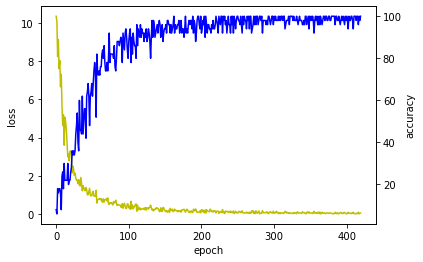

In [8]:
model.eval()

with torch.no_grad():
    correct = 0
    total = 0
    for data, label in train_dataset:
        output = model(data)
        preds  = torch.max(output.data, 1)[1]
        total   += len(label)
        
        label = label.reshape(50)
        correct += (preds==label).sum().item()
    print('Test Accuracy: ', 100.*correct/total)
    

%matplotlib inline
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(np.asarray(train_loss), 'y')
acc_ax.plot( np.asarray(train_acc),  'b')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

plt.show()